## Import

In [97]:
import pandas as pd

In [98]:
x = pd.read_csv("../data/x_raw.csv", index_col=0)
x.head()

,beer_description,brewery,ABV,IBU,global_rating,total
18433,IPA - New England,Norbrook Farm Brewery,7.5,45.0,3.81,1
18434,Brown Ale - American,Norbrook Farm Brewery,6.0,20.0,3.79,1
18435,Bière de Garde,Norbrook Farm Brewery,6.2,20.0,3.87,1
18436,IPA - American,Norbrook Farm Brewery,7.0,42.0,3.65,1
18437,Kölsch,Norbrook Farm Brewery,4.7,17.0,3.66,1


In [99]:
y = pd.read_csv("../data/y_raw.csv", index_col=0)
y.head()

,user_rating
18433,4.0
18434,4.0
18435,3.0
18436,3.5
18437,4.0


## Preprocessing

### Dummy Variables

Descriptions

In [100]:
description_dummies = pd.get_dummies(x['beer_description'])

In [101]:
description_dummies.sum().sort_values(ascending=False).head(15)

IPA - American                        611
IPA - Imperial / Double               330
Pale Ale - American                   191
IPA - New England                     167
IPA - Session / India Session Ale     100
Brown Ale - American                   78
Stout - American Imperial / Double     72
Porter - American                      72
Farmhouse Ale - Saison                 67
Stout - Oatmeal                        62
Porter - Other                         61
Stout - Milk / Sweet                   60
Stout - American                       56
Red Ale - American Amber / Red         56
Pumpkin / Yam Beer                     56
dtype: int64

In [102]:
# consolidate dummies, write new col to x
description_names = description_dummies.sum()[description_dummies.sum() >= 100].index.tolist()
x['description_consolidated'] = [val if val in description_names else 'Other' for val in x['beer_description']]

# drop Other, replace variables with dummies
description_dummies = pd.get_dummies(x['description_consolidated']).drop('Other', axis=1)

In [103]:
x = pd.merge(x, description_dummies, left_index=True, right_index=True)
x = x.drop(['beer_description', 'description_consolidated'], axis=1)
x.head()

,brewery,ABV,IBU,global_rating,total,IPA - American,IPA - Imperial / Double,IPA - New England,IPA - Session / India Session Ale,Pale Ale - American
18433,Norbrook Farm Brewery,7.5,45.0,3.81,1,0,0,1,0,0
18434,Norbrook Farm Brewery,6.0,20.0,3.79,1,0,0,0,0,0
18435,Norbrook Farm Brewery,6.2,20.0,3.87,1,0,0,0,0,0
18436,Norbrook Farm Brewery,7.0,42.0,3.65,1,1,0,0,0,0
18437,Norbrook Farm Brewery,4.7,17.0,3.66,1,0,0,0,0,0


Breweries

In [104]:
brewery_dummies = pd.get_dummies(x['brewery'])

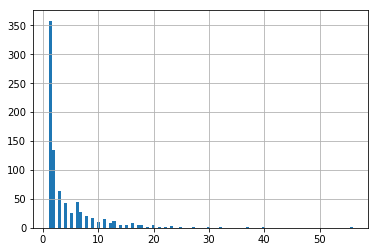

In [105]:
brewery_dummies.sum().sort_values(ascending=False).head(50)
brewery_dummies.sum().hist(bins=100)

In [106]:
# consolidate dummies, write new col to x
brewery_names = brewery_dummies.sum()[brewery_dummies.sum() > 10].index.tolist()
x['brewery_consolidated'] = [val if val in brewery_names else 'Other' for val in x['brewery']]

# drop Other, replace variables with dummies
brewery_dummies = pd.get_dummies(x['brewery_consolidated']).drop('Other', axis=1)

In [107]:
x = pd.merge(x, brewery_dummies, left_index=True, right_index=True)
x = x.drop(['brewery', 'brewery_consolidated'], axis=1)

In [108]:
x.head()

,ABV,IBU,global_rating,total,IPA - American,IPA - Imperial / Double,IPA - New England,IPA - Session / India Session Ale,Pale Ale - American,30 Mile Brewing Co.,...,SweetWater Brewing Company,Thimble Island Brewing Company,Thomas Hooker Brewing Co.,Top Shelf Brewing Company,Tree House Brewing Company,Trillium Brewing Company,Tröegs Independent Brewing,Two Roads Brewing Company,Veracious Brewing Company,Wicked Weed Brewing
18433,7.5,45.0,3.81,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18434,6.0,20.0,3.79,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18435,6.2,20.0,3.87,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18436,7.0,42.0,3.65,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18437,4.7,17.0,3.66,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Missing Values and Types

In [109]:
x.isna().sum().head(5)

ABV                 57
IBU               1367
global_rating        0
total                0
IPA - American       0
dtype: int64

In [110]:
x['ABV'] = x['ABV'].fillna(x['ABV'].mean())

In [111]:
import numpy as np
x['IBU'].fillna(value=np.nan, inplace=True)
x['IBU'].replace('None', np.nan, inplace=True)

x['IBU'].fillna(value='drop', inplace=True)

ibu_mean = x[x['IBU'].fillna('drop') != 'drop']['IBU'].astype('int').mean()
x['IBU'].replace('drop',ibu_mean, inplace=True)

In [112]:
x['IBU'] = x['IBU'].astype('float')
x.dtypes

ABV                                        float64
IBU                                        float64
global_rating                              float64
total                                        int64
IPA - American                               uint8
IPA - Imperial / Double                      uint8
IPA - New England                            uint8
IPA - Session / India Session Ale            uint8
Pale Ale - American                          uint8
30 Mile Brewing Co.                          uint8
ARMADA BREWING                               uint8
Alvarium Beer Company                        uint8
Aspetuck Brew Lab                            uint8
BAD SONS Beer Co.                            uint8
Back East Brewing Company                    uint8
Ballast Point Brewing Company                uint8
Barrier Brewing Company                      uint8
Beer'd Brewing Company                       uint8
Big Elm Brewing                              uint8
Black Hog Brewing Co.          

In [113]:
x.isna().sum().head(5)

ABV               0
IBU               0
global_rating     0
total             0
IPA - American    0
dtype: int64

In [114]:
y.fillna(y.mean(),inplace=True)

In [115]:
y.isna().any()

user_rating    False
dtype: bool

## Remove Outliers

## EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7717fa1d0>]],
      dtype=object)

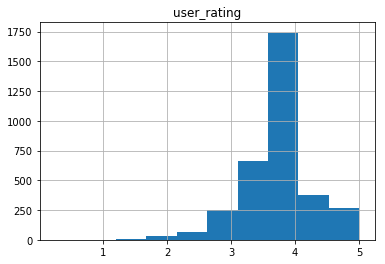

In [116]:
y.hist()

In [117]:
x.iloc[:,:4].corr()

,ABV,IBU,global_rating,total
ABV,1.000000,0.361751,0.297818,0.009177
IBU,0.361751,1.000000,0.179710,0.054792
global_rating,0.297818,0.179710,1.000000,0.092721
total,0.009177,0.054792,0.092721,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7717e1128>,
      dtype=object)

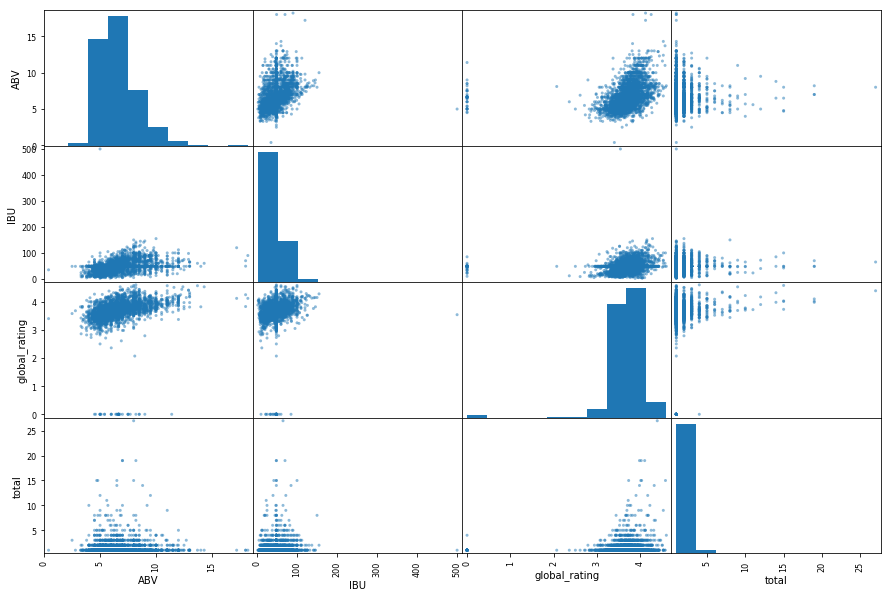

In [118]:
pd.plotting.scatter_matrix(x.iloc[:,:4], figsize=(15,10))

## Scaling

In [119]:
x.iloc[:,:4]

,ABV,IBU,global_rating,total
18433,7.50000,45.000000,3.81,1
18434,6.00000,20.000000,3.79,1
18435,6.20000,20.000000,3.87,1
18436,7.00000,42.000000,3.65,1
18437,4.70000,17.000000,3.66,1
18438,5.80000,30.000000,3.77,1
18439,8.20000,20.000000,3.88,1
18440,4.80000,25.000000,3.67,1
18441,6.80000,40.000000,4.06,1
18442,5.40000,17.000000,3.78,1


In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x.iloc[:,:4])
scaled = scaler.transform(x.iloc[:,:4])

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb77134ca20>,
      dtype=object)

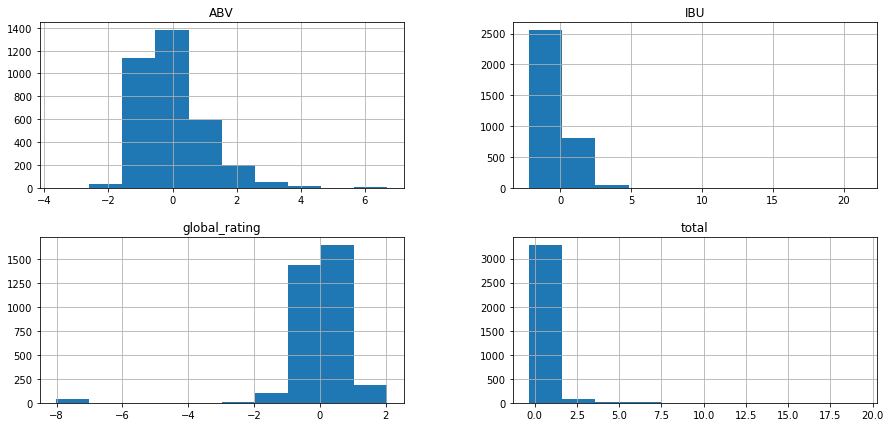

In [121]:
pd.DataFrame(scaled, columns=x.iloc[:,:4].columns).hist(figsize=(15,7))

In [122]:
x.iloc[:,:4] = scaled

## Modeling

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(x, y['user_rating'], test_size=0.2, random_state=12)

In [125]:
X_train.head()

,ABV,IBU,global_rating,total,IPA - American,IPA - Imperial / Double,IPA - New England,IPA - Session / India Session Ale,Pale Ale - American,30 Mile Brewing Co.,...,SweetWater Brewing Company,Thimble Island Brewing Company,Thomas Hooker Brewing Co.,Top Shelf Brewing Company,Tree House Brewing Company,Trillium Brewing Company,Tröegs Independent Brewing,Two Roads Brewing Company,Veracious Brewing Company,Wicked Weed Brewing
19775,-0.382043,0.000000,0.314495,-0.308574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19870,-0.440044,-0.953434,0.576676,-0.308574,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18910,-0.034040,0.000000,1.385067,1.196663,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18675,0.023960,1.015509,0.401889,-0.308574,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21303,-1.252050,-0.578397,-0.056928,-0.308574,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
y_train.head()

19775    4.25
19870    3.00
18910    4.50
18675    4.00
21303    3.50
Name: user_rating, dtype: float64

In [127]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [128]:
predictions = lasso.predict(X_test)

In [130]:
results_df = pd.DataFrame([predictions,y_test]).transpose()
results_df.columns = ['prediction', 'actual']

In [131]:
results_df.head()

,prediction,actual
0,3.828113,4.00
1,3.828113,3.25
2,3.828113,3.75
3,3.828113,4.00
4,3.828113,1.25


In [133]:
results_df['error'] = results_df['prediction'] - results_df['actual']
results_df.head()

,prediction,actual,error
0,3.828113,4.00,-0.171887
1,3.828113,3.25,0.578113
2,3.828113,3.75,0.078113
3,3.828113,4.00,-0.171887
4,3.828113,1.25,2.578113


In [134]:
avg_error = np.mean(results_df['error'])
std_error = np.std(results_df['error'])
print('avg error', avg_error, 
      '\n'
      'std of error', std_error)

avg error 0.018077382865431816 
std of error 0.5796704303353049


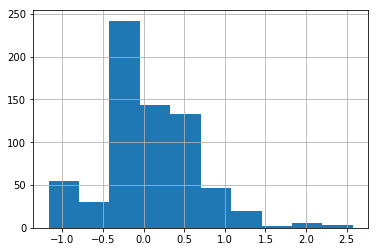

In [135]:
results_df['error'].hist()

In [136]:
rmse = np.sqrt(np.mean(results_df['error']**2))
rmse

0.5799522390476486

In [142]:
# iterate
alphas = np.linspace(0.1,1)

rmse_dict = {}
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    predictions = lasso.predict(X_test)
    
    errors = predictions - y_test
    rmse = np.sqrt(np.mean(errors**2))
    rmse_dict[a] = rmse

In [143]:
pd.DataFrame.from_dict(rmse_dict, orient='index').reset_index()

,index,0
0,0.100000,0.572341
1,0.118367,0.575489
2,0.136735,0.579086
3,0.155102,0.579952
4,0.173469,0.579952
5,0.191837,0.579952
6,0.210204,0.579952
7,0.228571,0.579952
8,0.246939,0.579952
9,0.265306,0.579952


In [144]:
lasso.coef_

array([-0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
        0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.,  0.,
        0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0., -0.])